In [ ]:
import json
from pandas import json_normalize
import re
import pandas as pd
from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import arabic_reshaper
from bidi.algorithm import get_display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
from lancedb.embeddings import EmbeddingFunction
from FlagEmbedding import BGEM3FlagModel
from pydantic import PrivateAttr
import lancedb
from pydantic import Field
from typing import Annotated
import numpy as np
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry

## 1. Preprocessing

In [68]:
with open('PerCQA_JSON_Format.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f)

df = json_normalize(data)
df.head()

,QID,QCATEGORY,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject,Comments
0,1550088,None,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,"[{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':..."
1,1558609,None,2018-01-06T00:17:00,6856,General,Not Applicable,khanoomi72,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟,"[{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':..."
2,1587820,None,2018-01-22T13:23:00,9918,General,Not Applicable,lol,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,کمک سالگرد ازدواجم نزدیکه,"[{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'..."
3,4414921,None,2020-05-23T02:06:00,81403,General,Not Applicable,sepide1400,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,متخصص ارتوپدی برای درمان پرانتزی پا,"[{'CID': '138006316', 'CUSERID': 38437, 'CGOLD..."
4,3109668,None,2019-08-13T12:07:00,25700,General,Not Applicable,نسا۷۹,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,لپ پسرم قرمز دون دونه,"[{'CID': '100859930', 'CUSERID': 33391, 'CGOLD..."


In [69]:
normalizer = Normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
stopwords = set(stopwords_list())

slang_dict = {
    "خخخ": "خنده",
    "ههه": "خنده",
    "ههههه": "خنده",
    "عه": "تعجب",
    "عههه": "تعجب",
    "مرسی": "ممنون",
    "دمت": "تشکر",
    "باحال": "جالب",
    "اوکی": "باشه",
}

def preprocess_text(text, replace_slang=True):
    if not isinstance(text, str):
        return text
    
    text = text.replace("ي", "ی").replace("ك", "ک")
    
    diacritics_pattern = re.compile(r'[\u064B-\u0652]')
    text = re.sub(diacritics_pattern, '', text)
    
    text = normalizer.normalize(text)
    
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    
    if replace_slang:
        for slang, standard in slang_dict.items():
            text = re.sub(rf"\b{slang}\b", standard, text)
    
    text = re.sub(r'[؟.!]', '', text)
    
    tokens = word_tokenize(text)
    
    tokens = [tok for tok in tokens if tok not in stopwords]
    
    tokens = [lemmatizer.lemmatize(stemmer.stem(tok)) for tok in tokens]
    
    return " ".join(tokens)

df["QBody_clean"] = df["QBody"].apply(preprocess_text)
df


,QID,QCATEGORY,QDATE,QUSERID,QTYPE,QGOLD_YN,QUsername,QBody,QSubject,Comments,QBody_clean
0,1550088,None,2018-01-01T12:14:00,9101,General,Not Applicable,sami1366,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,قهر شوهرم,"[{'CID': '50758322', 'CUSERID': 4918, 'CGOLD':...",دوس نامزد ( شوهر ) با قهره امروز تولدشه موضوع ...
1,1558609,None,2018-01-06T00:17:00,6856,General,Not Applicable,khanoomi72,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,بزرگترین اشتباه دوران نامزدیتون چی بوده؟؟,"[{'CID': '51114707', 'CUSERID': 3935, 'CGOLD':...",خود حس اشتباه گیر بیخود غر زدن زیادمه اشتباهات...
2,1587820,None,2018-01-22T13:23:00,9918,General,Not Applicable,lol,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,کمک سالگرد ازدواجم نزدیکه,"[{'CID': '52336355', 'CUSERID': 10255, 'CGOLD'...",سالگرد ازدواج نزدیکه چ بخر سالگرد دوممونه عقد ...
3,4414921,None,2020-05-23T02:06:00,81403,General,Not Applicable,sepide1400,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,متخصص ارتوپدی برای درمان پرانتزی پا,"[{'CID': '138006316', 'CUSERID': 38437, 'CGOLD...",دخ چهارده ماهه تشخیص پرانتز پا سالگی صبر متخصص...
4,3109668,None,2019-08-13T12:07:00,25700,General,Not Applicable,نسا۷۹,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,لپ پسرم قرمز دون دونه,"[{'CID': '100859930', 'CUSERID': 33391, 'CGOLD...",پماد بزن چیه اینجور واضح نیس بزور از عکس گرف
...,...,...,...,...,...,...,...,...,...,...,...
985,1582862,None,2018-01-19T14:50:00,9379,General,Not Applicable,مامان_مهراد_جونی,هدایایی که برای بله برون می برن تو شهرهای مختل...,بله برون. خانمای میشه بگید برای بله بران چه چی...,"[{'CID': '52145320', 'CUSERID': 10177, 'CGOLD'...",هدایا بله برون می‌برن شهر مختلف فرق داره اگه ا...
986,1790522,None,2018-05-20T00:46:00,12482,General,Not Applicable,_مهربانو_,براي اولين بار كره ي بادوم زميني خريدم ولي نمي...,با كره ي بادوم زميني چي درست كنم؟,"[{'CID': '59550231', 'CUSERID': 13736, 'CGOLD'...",کره بادو زمین خرید نمیدون با چ درس فردا افطار ...
987,1574016,None,2018-01-14T11:51:00,9753,General,Not Applicable,مارالان,من ۹ماهه که عقد کردم . نامزدم ماهی۱۱۰۰حقوقشه ت...,نامزدی,"[{'CID': '51780636', 'CUSERID': 9563, 'CGOLD':...",۹ ماهه عقد نامزد ماه ۱۱۰۰ حقوقشه ساع عصر سرکار...
988,4171615,None,2020-04-06T18:17:00,30885,General,Not Applicable,saghiiii,بچه ها از کی به نبودن شیر عادت میکنن؟ ۳ روزه گ...,از شیر گرفتن کودک,"[{'CID': '131471418', 'CUSERID': 6245, 'CGOLD'...",بچه ک نبودن شیر عاد میکنن ۳ روزه گرفت#گیر هنوز...


In [70]:
text = "ممنون از شما"
reshaped_text = arabic_reshaper.reshape(text)

bidi_text = get_display(reshaped_text)

print("Before:", text)
print("After:", bidi_text)


Before: ممنون از شما
After: ﺎﻤﺷ ﺯﺍ ﻥﻮﻨﻤﻣ


In [71]:
df.columns

Index(['QID', 'QCATEGORY', 'QDATE', 'QUSERID', 'QTYPE', 'QGOLD_YN',
       'QUsername', 'QBody', 'QSubject', 'Comments', 'QBody_clean'],
      dtype='object')

## 2. EDA

In [72]:
def extract_cbodies(comments):
    if isinstance(comments, list): 
        return [c.get("CBody", "") for c in comments if isinstance(c, dict)]
    elif isinstance(comments, dict): 
        return [comments.get("CBody", "")]
    else:
        return []

df["Comments_CBody"] = df["Comments"].apply(extract_cbodies)

for i, row in df[['QBody', 'Comments_CBody']].head(2).iterrows():
    print(f"Question {i+1}: {row['QBody']}")
    print("Answers:")
    for j, ans in enumerate(row['Comments_CBody'], 1):
        print(f"  {j}. {ans}")
    print("-"*80)


Question 1: دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چه کنم؟موضوع دعوامون چیزی بوده که من مقصرش نیستم...خودشم میدونه ربطی به من نداره
Answers:
  1. قهر جدا تولد جدا. ضمنا خواهرانه میگم این قهر و همین ابتدای زندگیت محوش کن عزیزم
  2. انقدر تحويلش نگير تا خودش بياد سمتت،اين جوري ادب مي شه كه ديگه قهر نكنه.. البته اگر طاقت مياري كه بهش زنگ نزني اينكاري كه گفتم رو انجام بدي بهترِ عزيزم.
  3. تولد براش بگير. قهر جداس
  4. تولدشون رو تبریک بگین . جوری که احساس نکنن دارین منت کشی میکنین . یعنی نشون بدین دلخورین . برا این میگم تبریک بگین تا بعداا حرف برا گفتن نداشته باشن .
  5. تو کادوت رو بخر و آماده بزار تا شب اگه زنگت نزد. خودت بهش بزنگ بیاد دنبالت بعد کادوشو بهش بده و آشتی کنین و شام برین بیرون چلو کباب برگ سفارش بدین باسوپ جو سالاد فصل و ماست موسیر و زیتون پرورده و دلستر لیمو😋😋
  6. . مرسی عزیزم...طاقت میارم اما دوری سردش میکنه. 
  7. . میدونم زنگ نمیزنه...اگرم من بزنم دنبالم نمیاد...خودم باید برم دنبالش
  8. . دیشب تبریک گفتم جوابی نداد امروزم زنگ زدم برخورد خوبی نداشت
  9. به نظرم ا

In [73]:
def extract_cbodies(comments):
    if isinstance(comments, list):
        return [c.get("CBody", "") for c in comments if isinstance(c, dict)]
    elif isinstance(comments, dict):
        return [comments.get("CBody", "")]
    else:
        return []

df["Comments_CBody"] = df["Comments"].apply(extract_cbodies)

answers = [ans for sublist in df["Comments_CBody"] for ans in sublist]
answers_df = pd.DataFrame({"Answer": answers})

df["Q_char_len"] = df["QBody"].astype(str).apply(len)
df["Q_word_len"] = df["QBody"].astype(str).apply(lambda x: len(x.split()))

answers_df["A_char_len"] = answers_df["Answer"].astype(str).apply(len)
answers_df["A_word_len"] = answers_df["Answer"].astype(str).apply(lambda x: len(x.split()))

print("Questions:")
print(" Avg chars:", df["Q_char_len"].mean())
print(" Median chars:", df["Q_char_len"].median())
print(" Avg words:", df["Q_word_len"].mean())
print(" Median words:", df["Q_word_len"].median())

print("\nAnswers:")
print(" Avg chars:", answers_df["A_char_len"].mean())
print(" Median chars:", answers_df["A_char_len"].median())
print(" Avg words:", answers_df["A_word_len"].mean())
print(" Median words:", answers_df["A_word_len"].median())


fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        "Histogram - Question Word Lengths",
        "Histogram - Answer Word Lengths",
        "Boxplot - Question Character Lengths",
        "Boxplot - Answer Character Lengths"
    )
)

fig.add_trace(
    go.Histogram(x=df["Q_word_len"], nbinsx=50, name="Questions", marker_color='blue'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=answers_df["A_word_len"], nbinsx=50, name="Answers", marker_color='green'),
    row=1, col=2
)

fig.add_trace(
    go.Box(x=df["Q_char_len"], name="Questions", marker_color='blue', boxmean=True),
    row=2, col=1
)

fig.add_trace(
    go.Box(x=answers_df["A_char_len"], name="Answers", marker_color='green', boxmean=True),
    row=2, col=2
)

fig.update_layout(
    height=700, width=900,
    title_text="Questions and Answers Length Analysis",
    showlegend=False
)

fig.show()



Questions:
 Avg chars: 172.93232323232323
 Median chars: 129.0
 Avg words: 35.1030303030303
 Median words: 26.0

Answers:
 Avg chars: 97.23833348494496
 Median chars: 67.0
 Avg words: 19.288592740835078
 Median words: 13.0


In [74]:
df["num_answers"] = df["Comments_CBody"].apply(len)

most_engaging = df.sort_values(by="num_answers", ascending=False)

print("Top 10 Most Engaging Questions:")
most_engaging[["QID", "QBody", "num_answers"]].head(10)


Top 10 Most Engaging Questions:


,QID,QBody,num_answers
571,1556257,با ١٥ تومن چه چيزاي از جهاز و ميشه خريد ؟! كه ...,315
152,1577970,کسی اطلاع داره بخوابم پیش ایشون بريم چطوری و ک...,313
342,1559359,بعد طلاق چطور خودتونو سرپا نگه داشتین. چطور خو...,215
728,1555428,من یه سال نامزد کردم قرار یه سال دیگه هم نامزد...,215
194,1578477,بیاین بگین چیکار میکنین نازتونو میکشه؟. من شوه...,166
969,1569562,ما عقد هستیم.شوهرم اصلا خسیس نیست هر چی بخوام ...,144
256,1591164,شوهرتون ماشین جدید بخره ناراحت میشید به نام شم...,143
628,1585904,استخاره زدم بد اومد ترسیدم واقعا از اینکه الان...,137
677,1567278,سلام دوستان چند روز آینده قراره واسم خواستگار ...,137
8,1575297,شوهرم همش بهانه میگیره همش دعوا.میگه توهیچی به...,136


In [75]:
total_questions = df.shape[0]
questions_with_answers = (df["num_answers"] > 0).sum()
questions_without_answers = total_questions - questions_with_answers

print(f"Total questions: {total_questions}")
print(f"Questions with at least one answer: {questions_with_answers}")
print(f"Questions without answers: {questions_without_answers}")
print(f"Average number of answers per question: {round(df['num_answers'].mean()):.2f}")
print(f"Median number of answers per question: {df['num_answers'].median()}")


Total questions: 990
Questions with at least one answer: 990
Questions without answers: 0
Average number of answers per question: 22.00
Median number of answers per question: 15.0


In [209]:
all_comments = []
for _, row in df.iterrows():
    qid = row['QID']
    for c in row['Comments']:
        if isinstance(c, dict) and 'CDate' in c:
            all_comments.append({
                'QID': qid,
                'CBody': c.get('CBody', ''),
                'CDate': c['CDate']
            })

comments_df = pd.DataFrame(all_comments)

comments_df['CDate'] = pd.to_datetime(comments_df['CDate'])


In [210]:
comments_df['hour'] = comments_df['CDate'].dt.hour
comments_df['day_of_week'] = comments_df['CDate'].dt.day_name()

hourly_activity = comments_df.groupby('hour').size().reset_index(name='count')

daily_activity = comments_df.groupby('day_of_week').size().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index(name='count')


In [211]:
fig_hour = px.bar(hourly_activity, x='hour', y='count', 
                  title='User Activity by Hour',
                  labels={'count':'Number of Comments', 'hour':'Hour of Day'},
                  color='count')
fig_hour.show()

fig_day = px.bar(daily_activity, x='day_of_week', y='count',
                 title='User Activity by Day of Week',
                 labels={'count':'Number of Comments', 'day_of_week':'Day'},
                 color='count')
fig_day.show()


In [212]:
heatmap_data = comments_df.pivot_table(
    index=comments_df['day_of_week'],
    columns=comments_df['hour'],
    values='CBody',
    aggfunc='count'
).reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

fig_heat = px.imshow(heatmap_data,
                     labels=dict(x="Hour", y="Day of Week", color="Number of Comments"),
                     x=list(range(24)),
                     y=heatmap_data.index,
                     aspect="auto",
                     color_continuous_scale='Viridis')
fig_heat.update_layout(title="Heatmap of User Activity (Day vs Hour)")
fig_heat.show()


In [213]:
all_comments = []
for _, row in df.iterrows():
    for c in row['Comments']:
        if isinstance(c, dict):
            all_comments.append({
                'QID': row['QID'],
                'CUsername': c.get('CUsername', 'Unknown'),
                'CBody': c.get('CBody', ''),
                'CDate': c.get('CDate', None)
            })

comments_df = pd.DataFrame(all_comments)


In [214]:
user_counts = comments_df.groupby('CUsername').size().reset_index(name='num_answers')

top_users = user_counts.sort_values(by='num_answers', ascending=False).head(10)
top_users


,CUsername,num_answers
3200,باران_بهاری95,142
3280,بلوبری۳۲۳۷,96
376,a_rezoo,93
2249,saghiiii,89
4551,عسلیk516,86
159,69_fahime,84
4845,مارالان,82
4654,فرزان11,82
2990,اردیبهشت_رویایی,81
867,es,75


In [82]:
fig = px.bar(top_users, x='CUsername', y='num_answers',
             title='Top 10 Answer Contributors',
             labels={'num_answers':'Number of Answers', 'CUsername':'User'},
             text='num_answers',
             color='num_answers',
             color_continuous_scale='Viridis')

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_tickangle=-45)
fig.show()


In [ ]:
normalizer = Normalizer()
persian_stopwords = set(stopwords_list())

persian_punctuations = set("،؛؟«»…٪٫()[]{}!؟:؛،.؟\"'\\/|@#$%^&*-+=~`")

filter_tokens = persian_stopwords.union(persian_punctuations)

all_questions = " ".join(df['QBody'].astype(str))
all_answers = " ".join([ans for sublist in df['Comments_CBody'] for ans in sublist])

q_tokens = word_tokenize(normalizer.normalize(all_questions))
a_tokens = word_tokenize(normalizer.normalize(all_answers))

q_tokens_clean = [t for t in q_tokens if t not in filter_tokens and t.strip()]
a_tokens_clean = [t for t in a_tokens if t not in filter_tokens and t.strip()]

def get_top_words(tokens, top_k=20):
    return Counter(tokens).most_common(top_k)

top_q_words_before = get_top_words(q_tokens)
top_a_words_before = get_top_words(a_tokens)
top_q_words_after = get_top_words(q_tokens_clean)
top_a_words_after = get_top_words(a_tokens_clean)

print("Top Question Words (before cleaning):", top_q_words_before)
print("Top Question Words (after cleaning):", top_q_words_after)
print("Top Answer Words (before cleaning):", top_a_words_before)
print("Top Answer Words (after cleaning):", top_a_words_after)

Top Question Words (before cleaning): [('.', 1764), ('و', 1085), ('؟', 1051), ('که', 552), ('از', 493), ('من', 447), ('به', 420), ('رو', 345), ('کنم', 314), ('هم', 301), ('خیلی', 285), ('تو', 256), ('،', 249), ('با', 239), ('یا', 222), ('ولی', 220), ('یه', 214), ('داره', 214), ('هست', 214), ('تا', 199)]
Top Question Words (after cleaning): [('یه', 214), ('داره', 214), ('هست', 214), ('میشه', 195), ('باشه', 176), ('الان', 170), ('چی', 143), ('دخترم', 141), ('میکنه', 141), ('بچه', 137), ('بهش', 128), ('ماهشه', 126), ('پسرم', 124), ('چیکار', 118), ('دارم', 109), ('شیر', 105), ('دکتر', 105), ('بهم', 101), ('دیگه', 99), ('بدم', 96)]
Top Answer Words (before cleaning): [('.', 28216), ('و', 9927), ('من', 5487), ('که', 5486), ('به', 5465), ('از', 4986), ('هم', 3728), ('،', 3691), ('رو', 3526), ('تو', 3166), ('؟', 3121), ('..', 3116), ('خیلی', 3101), ('یه', 3094), ('با', 3090), ('این', 2677), ('ولی', 2637), ('تا', 2213), ('فقط', 2111), ('میشه', 1887)]
Top Answer Words (after cleaning): [('..', 3

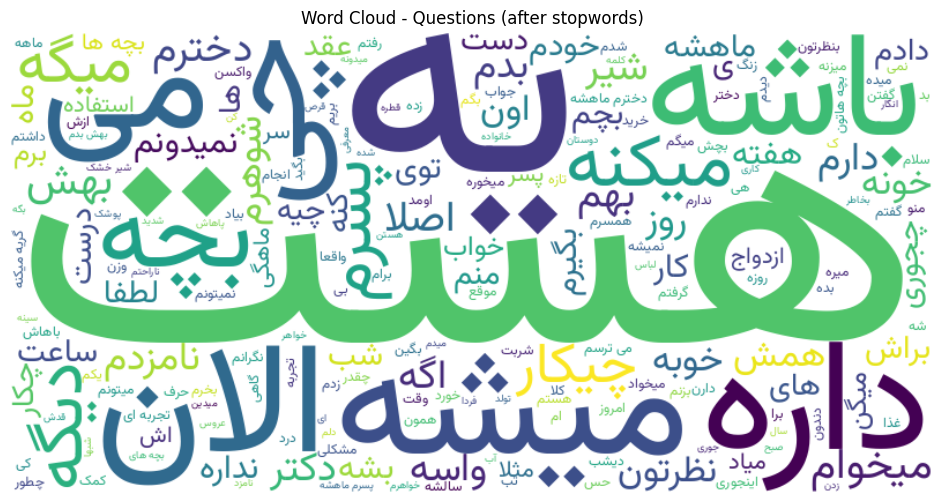

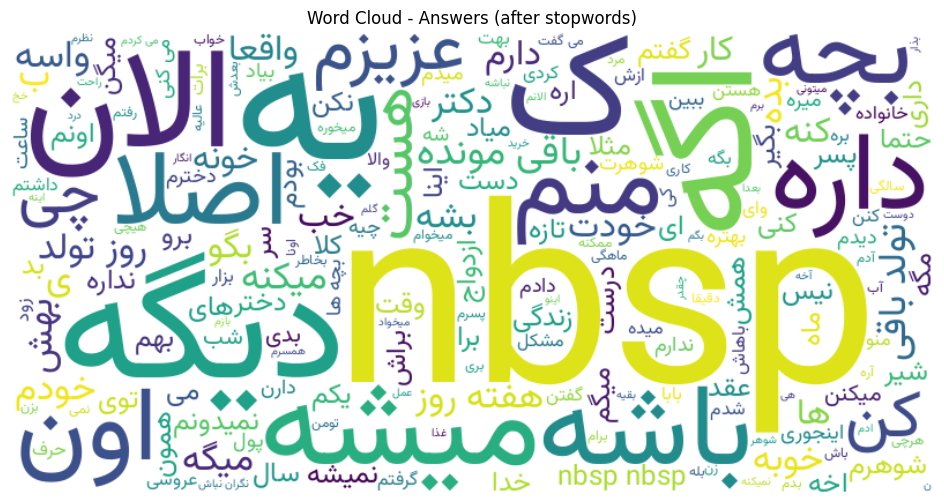

In [195]:
font_path = "Vazirmatn-Regular.ttf"

def plot_wordcloud(tokens, title):
    wc = WordCloud(width=800, height=400, background_color='white',
                   font_path=font_path).generate(" ".join(tokens))
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

plot_wordcloud(q_tokens_clean, "Word Cloud - Questions (after stopwords)")
plot_wordcloud(a_tokens_clean, "Word Cloud - Answers (after stopwords)")


In [196]:
def get_top_ngrams(tokens, n=2, top_k=20):
    n_grams = ngrams(tokens, n)
    return Counter(n_grams).most_common(top_k)

# Unigrams
top_q_unigrams = get_top_ngrams(q_tokens_clean, 1)
top_a_unigrams = get_top_ngrams(a_tokens_clean, 1)

# Bigrams
top_q_bigrams = get_top_ngrams(q_tokens_clean, 2)
top_a_bigrams = get_top_ngrams(a_tokens_clean, 2)

# Trigrams
top_q_trigrams = get_top_ngrams(q_tokens_clean, 3)
top_a_trigrams = get_top_ngrams(a_tokens_clean, 3)


In [ ]:
def plot_top_ngrams(counter_list, title):
    ngram_str = [" ".join(tup) if isinstance(tup, tuple) else tup for tup, _ in counter_list]
    counts = [count for _, count in counter_list]
    
    fig = px.bar(
        x=ngram_str,
        y=counts,
        title=title,
        labels={'x': 'N-gram', 'y': 'Count'},
        text=counts,
        color=counts,
        color_continuous_scale='Viridis'
    )
    
    fig.update_traces(textposition='outside')
    fig.show()


plot_top_ngrams(top_q_unigrams, "Top Question Unigrams")
plot_top_ngrams(top_a_unigrams, "Top Answer Unigrams")
plot_top_ngrams(top_q_bigrams, "Top Question Bigrams")
plot_top_ngrams(top_a_bigrams, "Top Answer Bigrams")
plot_top_ngrams(top_q_trigrams, "Top Question Trigrams")
plot_top_ngrams(top_a_trigrams, "Top Answer Trigrams")


## 3. Analyse the dataset

In [87]:
from FlagEmbedding import BGEM3FlagModel

model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)


Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

In [88]:
sample_row = df.sample(1).iloc[0]
qbody_sample = sample_row['QBody']

embedding = model.encode([qbody_sample], max_length=8192)['dense_vecs'][0]

print("QID:", sample_row['QID'])
print("Embedding length:", len(embedding))
print("First 10 dimensions:", embedding[:10])


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


QID: 3395447
Embedding length: 1024
First 10 dimensions: [-0.01458647  0.02433824 -0.04119255  0.00146916 -0.0424397  -0.059041
  0.01560025  0.0184018   0.01571864 -0.01186331]


In [ ]:
class BgeM3EmbeddingFunction(EmbeddingFunction):
    _model: BGEM3FlagModel = PrivateAttr()
    
    def __init__(self):
        super().__init__()
        self._model = BGEM3FlagModel('BAAI/bge-m3', use_fp16=True)
    
    def compute_query_embeddings(self, queries: list) -> np.ndarray:
        embeddings = self._model.encode(queries, max_length=8192)['dense_vecs']
        return np.array(embeddings)
    
    def compute_source_embeddings(self, sources: list) -> np.ndarray:
        embeddings = self._model.encode(sources, max_length=8192)['dense_vecs']
        return np.array(embeddings)

    @property
    def ndims(self) -> int:
        return 1024  # The dimensionality of the embeddings from the bge-m3 model


In [164]:
embedding_func = get_registry().get("sentence-transformers").create()

class QuestionEntry(LanceModel):
    qid: str
    qbody: str = embedding_func.SourceField()
    embedding: Vector(embedding_func.ndims()) = embedding_func.VectorField()

db = lancedb.connect("nini_site_db")

if "questions" in db.table_names():
    db.drop_table("questions")
    print("Table 'questions' deleted successfully.")
else:
    table = db.create_table(name="questions", schema=QuestionEntry)
    print("Schema for 'questions' table created successfully.")



Schema for 'questions' table created successfully.


In [165]:
data_to_insert = []
for _, row in df.iterrows():
    data_to_insert.append({
        "qid": row['QID'],
        "qbody": row['QBody'],
    })

table.add(data_to_insert)

print("Data successfully inserted into the 'questions' table.")

Data successfully inserted into the 'questions' table.


In [179]:
table.to_pandas()

,qid,qbody,embedding
0,1550088,دوستان نامزدم (شوهرم)باهام قهره امروز تولدشه چ...,"[-0.019125178, 0.099479295, -0.07347038, 0.004..."
1,1558609,من خودم حس میکنم اشتباهم گیر دادن بیخودی و غر ...,"[0.02656599, 0.02164723, -0.03400926, 0.036327..."
2,1587820,سالگرد ازدواجم نزدیکه چی بخرم. سالگرد دوممونه....,"[-0.013627377, 0.053788126, -0.016664252, 0.01..."
3,4414921,دختر من چهارده ماهه است. آیا برای تشخیص پرانتز...,"[0.019605175, 0.09203873, -0.0117374845, 0.029..."
4,3109668,چه پمادی بزنم و از چیه اینجور شده . واضح نیس...,"[-0.015349397, 0.08209522, -0.092893764, 0.027..."
...,...,...,...
985,1582862,هدایایی که برای بله برون می برن تو شهرهای مختل...,"[0.011378793, 0.047294963, -0.062306948, -0.00..."
986,1790522,براي اولين بار كره ي بادوم زميني خريدم ولي نمي...,"[0.011454335, 0.026831964, -0.03298005, -0.002..."
987,1574016,من ۹ماهه که عقد کردم . نامزدم ماهی۱۱۰۰حقوقشه ت...,"[0.023197755, 0.03593181, 0.0011408555, 0.0207..."
988,4171615,بچه ها از کی به نبودن شیر عادت میکنن؟ ۳ روزه گ...,"[0.010582658, 0.056691665, -0.05657063, -0.005..."


In [183]:
user_queries = [
    "برای تب بچم چی کار کنم؟",
    "سریال و فیلم چی ببینم؟",
    "پای بچه‌ام پرانتزیه، باید نگران باشم؟",
    "سالگرد ازدواجم چی بخرم؟",
    "اوتیسم چه نشانه هایی دارد؟"
]

embedding_func = get_registry().get("sentence-transformers").create()
query_embeddings = embedding_func.compute_query_embeddings(user_queries)

for query, embedding in zip(user_queries, query_embeddings):
    print(f"\nQuery: {query}")
    results = table.search(embedding).limit(5).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}\n")


Query: برای تب بچم چی کار کنم؟
Result 1: چطور دکتریه؟کسی بچش برده

Result 2: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟

Result 3: دور سر پسربچه هاتون تو ۵ ماه و نیم چقدر بوده؟

Result 4: چه کسایی با  ای وی اف  باردار شدن چجوری؟ هزینش چقدر بود؟

Result 5: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟


Query: سریال و فیلم چی ببینم؟
Result 1: سریال به جز دل و کرگدن الان چی هست؟

Result 2: چرا سامانه سهام عدالت بالا نمیاد؟

Result 3: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟

Result 4: چند درجه روشن میکنه ؟ چندجلسه ؟ هزینش چی

Result 5: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟


Query: پای بچه‌ام پرانتزیه، باید نگران باشم؟
Result 1: آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟

Result 2: برای آینده بچه هاتون چطوری پس انداز میکنین از چه روشی؟

Result 3: بازی با پسربچه ۲ ساله. پیشنهادتون چیه؟ 

Result 4: بچه حدود چند سالگی میتونه از پله بالا بره ؟ 

Result 5: هزینه پر کردن دندون باعصب کشی

In [192]:
table.create_fts_index("qbody", replace=True)

for query in user_queries:
    print(f"\nQuery: {query}")
    results = table.search(query).limit(5).select(["qid", "qbody"]).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}")



Query: برای تب بچم چی کار کنم؟
Result 1: چطور دکتریه؟کسی بچش برده
Result 2: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟
Result 3: دور سر پسربچه هاتون تو ۵ ماه و نیم چقدر بوده؟
Result 4: چه کسایی با  ای وی اف  باردار شدن چجوری؟ هزینش چقدر بود؟
Result 5: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟

Query: سریال و فیلم چی ببینم؟
Result 1: سریال به جز دل و کرگدن الان چی هست؟
Result 2: چرا سامانه سهام عدالت بالا نمیاد؟
Result 3: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟
Result 4: چند درجه روشن میکنه ؟ چندجلسه ؟ هزینش چی
Result 5: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟

Query: پای بچه‌ام پرانتزیه، باید نگران باشم؟
Result 1: آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟
Result 2: برای آینده بچه هاتون چطوری پس انداز میکنین از چه روشی؟
Result 3: بازی با پسربچه ۲ ساله. پیشنهادتون چیه؟ 
Result 4: بچه حدود چند سالگی میتونه از پله بالا بره ؟ 
Result 5: هزینه پر کردن دندون باعصب کشی چقدره؟  بچه ۳

In [215]:
from lancedb.rerankers import CrossEncoderReranker

user_queries = [
    "برای تب بچم چی کار کنم؟",
    "سریال و فیلم چی ببینم؟",
    "پای بچه‌ام پرانتزیه، باید نگران باشم؟",
    "سالگرد ازدواجم چی بخرم؟",
    "اوتیسم چه نشانه هایی دارد؟"
]

embedding_func = get_registry().get("sentence-transformers").create()
query_embeddings = embedding_func.compute_query_embeddings(user_queries)

for query, embedding in zip(user_queries, query_embeddings):
    print(f"\nQuery: {query}")
    results = table.search(embedding).limit(5).to_pandas()
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']}\n")

reranker = CrossEncoderReranker(model_name="cross-encoder/ms-marco-TinyBERT-L-6", column="qbody")

print("\nReranked Results")
reranked_results = []
for query in user_queries:
    results = table.search(query).limit(5).select(["qid", "qbody"]).rerank(reranker=reranker).to_pandas()
    reranked_results.append(results)
    print(f"\nQuery: {query}")
    for i, row in results.iterrows():
        print(f"Result {i+1}: {row['qbody']} (Score: {row['_relevance_score']:.4f})")




Query: برای تب بچم چی کار کنم؟
Result 1: چطور دکتریه؟کسی بچش برده

Result 2: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟

Result 3: دور سر پسربچه هاتون تو ۵ ماه و نیم چقدر بوده؟

Result 4: چه کسایی با  ای وی اف  باردار شدن چجوری؟ هزینش چقدر بود؟

Result 5: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟


Query: سریال و فیلم چی ببینم؟
Result 1: سریال به جز دل و کرگدن الان چی هست؟

Result 2: چرا سامانه سهام عدالت بالا نمیاد؟

Result 3: کسی تجربه دیدن چندتا موی سفید روی سر کودک زیر دوسال داشته؟

Result 4: چند درجه روشن میکنه ؟ چندجلسه ؟ هزینش چی

Result 5: چه کسانی بیمارستان چمران  زایمان کردن؟ ساک برا بچه ام میدن؟ توش چیا هست؟


Query: پای بچه‌ام پرانتزیه، باید نگران باشم؟
Result 1: آزمایشی  بردین بچه هاتون و بعد از یک سالگی ؟ لازم هست؟

Result 2: برای آینده بچه هاتون چطوری پس انداز میکنین از چه روشی؟

Result 3: بازی با پسربچه ۲ ساله. پیشنهادتون چیه؟ 

Result 4: بچه حدود چند سالگی میتونه از پله بالا بره ؟ 

Result 5: هزینه پر کردن دندون باعصب کشی

### What is Hybrid Search?

**Hybrid search** is a search technique that combines two or more different types of search methodologies to improve the overall accuracy, recall, and relevance of search results. It typically integrates both **vector-based semantic search** and **keyword-based traditional search** (e.g., **full-text search**) to take advantage of the strengths of both approaches.

### Components of Hybrid Search

1. **Semantic Search (Vector Search)**:

   * Semantic search uses **embeddings** (vector representations of text) to measure **semantic similarity** between the query and documents (or questions). It can handle synonyms, paraphrased phrases, and context-based queries better than keyword-based search.
   * It relies on models like **transformers**, **BERT**, **GPT**, or **word2vec** to capture the meaning behind words and phrases, rather than relying on exact word matches.
   * Example: If you search for "best gift for anniversary", semantic search will find results like "top gifts for wedding anniversary", even though the words differ, because it understands the **meaning**.

2. **Traditional Search (Keyword Search or Full-Text Search)**:

   * Full-text search relies on indexing documents by their **words** (tokens) and then finding exact or partial matches to the query. It doesn't understand **meaning** but looks for **word matches** or **keywords** within documents.
   * This method is fast and works well when the query and the document use the **same terminology**.
   * Example: A query like "best gift for anniversary" will only match documents that explicitly contain the keywords **"best"**, **"gift"**, **"anniversary"**.

### How Hybrid Search Works

In hybrid search, **semantic search** and **keyword search** are combined to take advantage of both:

1. **Initial Keyword Search**:

   * First, a **full-text search** is performed to retrieve documents that contain the query keywords. This quickly narrows down the set of documents.
2. **Refinement with Semantic Search**:

   * Then, **semantic search** is applied to the results of the keyword search to rank the results based on meaning, allowing for more contextually relevant results.
3. **Combining Results**:

   * The results from both methods are combined, typically by **merging** or **re-ranking** the documents, ensuring that both keyword matches and semantically similar documents appear in the final search results.

### Why Hybrid Search Might Be More Effective Than Using One Method Alone

1. **Keyword Search Strengths**:

   * **Fast and Efficient**: Full-text search is typically faster because it relies on well-established indexing and can quickly find documents based on the presence of keywords.
   * **High Precision for Exact Matches**: If the query contains highly specific terms or phrases, traditional search ensures that only those documents with the exact terms appear in the results.
   * **Well-Established for Structured Data**: Full-text search works particularly well for **structured** or **static** data, where exact matches are most relevant.

2. **Semantic Search Strengths**:

   * **Understanding Context**: Semantic search goes beyond **exact matches** by understanding the **meaning** behind the words. This allows it to find documents that are contextually similar, even if the query terms don't appear explicitly in the text.
   * **Handling Synonyms and Variations**: Semantic search can handle variations in phrasing, synonyms, or changes in the way a query is expressed. This is especially useful in cases where users might not know the exact terminology.
   * **Better for Complex Queries**: For queries that are more abstract or involve paraphrasing (e.g., "What are the best gifts for an anniversary?" vs. "What should I gift for my anniversary?"), semantic search is much more effective.

3. **Combining the Strengths**:

   * **Speed + Accuracy**: Full-text search can narrow down results quickly, and semantic search can refine those results by adding meaning-based ranking. This combination provides both **speed** and **accuracy** in the search process.
   * **More Robust Results**: Keyword-based search will fail in cases where the exact words don’t match, but semantic search will capture meaning. Similarly, semantic search can fail to capture results for queries that rely on very specific keywords. By combining both, you get results that are both **precise** and **contextually relevant**.
   * **Re-ranking with Context**: After full-text search retrieves the results based on exact matches, semantic search can re-rank them based on meaning, ensuring that the most contextually similar documents are returned at the top, even if they don’t match exactly.

### Common Evaluation Metrics for Search Systems

When evaluating the effectiveness of a search system (whether it's based on **semantic search** or **full-text search**), it’s important to use a set of **evaluation metrics** that can objectively assess how well the system is performing. Below are some of the most commonly used evaluation metrics for search systems:

### 1. **Precision\@k** (Precision at k)

* **Definition**: Precision\@k measures the proportion of relevant documents among the top **k** results returned by the search system.
* **Formula**:

  $$
  \text{Precision@k} = \frac{\text{Number of relevant documents in top } k \text{ results}}{k}
  $$
* **Usage**: If your search system returns 5 results, and 3 of them are relevant, **Precision\@5** would be 0.6 (i.e., 3 out of 5).
* **Interpretation**: High precision at k means the search system is effective at returning relevant results within the top-k ranking positions.

### 2. **Recall\@k** (Recall at k)

* **Definition**: Recall\@k measures the proportion of relevant documents retrieved in the top **k** results out of the total relevant documents in the dataset.
* **Formula**:

  $$
  \text{Recall@k} = \frac{\text{Number of relevant documents in top } k \text{ results}}{\text{Total number of relevant documents in the dataset}}
  $$
* **Usage**: Recall\@k is used to evaluate whether the search system is retrieving most of the relevant documents in the top k results. If the system finds 3 relevant documents in the top 5 results out of 10 relevant documents in total, Recall\@5 will be 0.3.
* **Interpretation**: High recall at k means the search system is retrieving a large proportion of the relevant documents, but it might also retrieve some irrelevant documents.


### 3. **Normalized Discounted Cumulative Gain (NDCG)**

* **Definition**: NDCG measures the ranking quality by considering both the relevance of the results and their positions in the ranking. It penalizes the relevance of documents appearing lower in the list.
* **Formula**:

  $$
  \text{NDCG@k} = \frac{DCG@k}{IDCG@k}
  $$

  Where $DCG@k$ is the **Discounted Cumulative Gain** and $IDCG@k$ is the **Ideal Discounted Cumulative Gain**.
* **DCG** is calculated as:

  $$
  DCG@k = \sum_{i=1}^{k} \frac{relevance_i}{\log_2(i+1)}
  $$

  * **Relevance**: Relevance score of the document at position $i$ in the ranking.
  * $\log_2(i+1)$ is used to discount the relevance of documents that appear later in the ranking.
* **Usage**: NDCG evaluates how well the search system ranks relevant documents at the top positions.
* **Interpretation**: A higher NDCG score indicates that more relevant documents appear higher in the list, which is desirable.


### 4. **Mean Reciprocal Rank (MRR)**

* **Definition**: MRR is the average of the **reciprocal ranks** of the first relevant document in the result set across multiple queries.
* **Formula**:

  $$
  \text{MRR} = \frac{1}{Q} \sum_{q=1}^{Q} \frac{1}{rank(q)}
  $$

  Where $rank(q)$ is the rank position of the first relevant document for query $q$.
* **Usage**: MRR is useful when evaluating whether the search system returns relevant documents at the **top of the list**.
* **Interpretation**: A higher MRR indicates that the search system tends to rank the first relevant document higher.

